In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # .experiments

Mounted at /content/gdrive


In [ ]:
import pickle
import scipy.signal
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np


In [ ]:


def load_data(file_name):
    with open(f'/content/gdrive/My Drive/SSVEP_BR41N_IO/{file_name}.pickle', 'rb') as f:
        data = pickle.load(f)
        eegs, labels = data['eegs'], data['labels']
    return eegs, labels

def filter_eeg(eeg_signal):
    b1, a1 =scipy.signal.butter(N=6, Wn=[0.5, 30], btype='bandpass', fs=256)
    b2, a2 =scipy.signal.iirnotch(w0= 50, Q=30, fs=256)


    filtered_eeg = scipy.signal.filtfilt(b1, a1, eeg_signal)
    filtered_eeg2 = scipy.signal.filtfilt(b2, a2, filtered_eeg)
    return filtered_eeg2

In [ ]:
subject=2

eeg_run1, labels_run1 = load_data(f"data_sub{subject}_train1")
eeg_run2, labels_run2 = load_data(f"data_sub{subject}_train2")

In [ ]:
eeg_run1 = filter_eeg(eeg_run1)
eeg_run2 = filter_eeg(eeg_run2)

labels_run1= np.array(labels_run1)-1
labels_run2= np.array(labels_run2)-1

## Power Spectral Analysis

In [ ]:
dt = 1/ 256  # 256 Hz sampling
pywt.scale2frequency('cmor1.5-1.0', [28.4, 25.6, 21.33, 17.06]) / dt # desired freqs: 9, 10, 12, 15


array([ 9.01408451, 10.        , 12.00187529, 15.00586166])

[ 9.01408451 10.         12.00187529 15.00586166]


<Figure size 360x360 with 0 Axes>

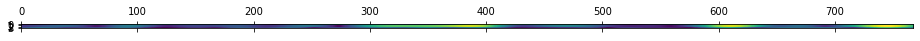

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

channel= eeg_run1[0,0]
y = channel
coef, freqs=pywt.cwt(y,[28.4, 25.6, 21.33, 17.06],'cmor1.5-1.0') # corf.shape: (4, 768) -> (0-> 9Hz, 1-> 10HZ, ETC) 
plt.figure(figsize=(5,5))
plt.matshow(np.abs(coef))
print(freqs*256)

In [ ]:
img = list(np.abs(coef[0])*np.ones((100, 768))) + list(np.abs(coef[1])*np.ones((100, 768))) + list(np.abs(coef[2])*np.ones((100, 768))) + list(np.abs(coef[3])*np.ones((100, 768)))

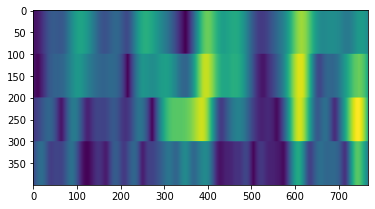

In [ ]:
plt.imshow(img)

In [ ]:
def obtain_cwt(eeg_signals, scale_arr= [28.4, 25.6, 21.33, 17.06]): # returns cwt with 4 scales correspinds to 9, 10, 12, 15 Hz
    eeg_cwt=[]
    for eeg_signal in eeg_signals:
        cwt_channels=[]
        for channel in eeg_signal:
            cwt_channels.append(np.abs(pywt.cwt(channel,scale_arr,'cmor1.5-1.0')[0]))
        eeg_cwt.append(cwt_channels)
    return np.array(eeg_cwt)



In [ ]:
def obtain_power_festures_per_channel(cwt_2d):
    power_plot=[]
    for freq_ax in cwt_2d:
        power_plot.append(np.sum(np.square(np.abs(freq_ax))))
    return np.array(power_plot)

def obtain_power_features(cwt_3d):
    power_features=[]
    for cwt_2d in cwt_3d:
        power_features+=list(obtain_power_festures_per_channel(cwt_2d))
    return np.array(power_features) # returns (32,) array for single sample

def get_power_dataset(cwt_dataset):
    dataset=[]
    for cwt_sample in cwt_dataset:
        dataset.append(obtain_power_features(cwt_sample)) # returns (32,) feature vector
    return np.array(dataset)

In [ ]:
import time

subject=2

eeg_run1, labels_run1 = load_data(f"data_sub{subject}_train1")
eeg_run2, labels_run2 = load_data(f"data_sub{subject}_train2")

start = time.time()

eeg_run1 = filter_eeg(eeg_run1)
eeg_run2 = filter_eeg(eeg_run2)

cwt_run1 = obtain_cwt(eeg_run1)
cwt_run2 = obtain_cwt(eeg_run2)

power_run1 = get_power_dataset(cwt_run1)
power_run2 = get_power_dataset(cwt_run2)

end= time.time()
print(f'mean time for feature extraction : {(end- start)/(power_run1.shape[0]+power_run2.shape[0])}')

mean time for feature extraction : 0.01334221065044403


In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = power_run2
y = labels_run2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train = power_run1
#y_train = labels_run1
#X_test = power_run2
#y_test = labels_run2

from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
print(f'train acc : {clf.score(X_train,y_train)} \ntest acc : {clf.score(X_test,y_test)}')

train acc : 0.8214285714285714 
test acc : 0.3333333333333333


In [ ]:
################  ALL_MODELS ######################

import sklearn
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.tree import *


# common models
model1=KNeighborsClassifier()
model2=RadiusNeighborsClassifier(radius=10)
model3=PassiveAggressiveClassifier()
model4=RidgeClassifier()
model5=RidgeClassifierCV()
model6=SGDClassifier()
model7=LinearSVC()
model8=NuSVC()
model9=SVC()
model10=DecisionTreeClassifier()
model11=ExtraTreeClassifier()

#models_from_ensemble
model12=AdaBoostClassifier()
model13=BaggingClassifier()
model14=ExtraTreesClassifier(n_estimators=1000)
model15=GradientBoostingClassifier()
model16=RandomForestClassifier()

# Using multiple models

estimators=[('model2',model2),('model12',model12),('model14',model14) ]

model17=StackingClassifier(estimators = estimators)
model18=VotingClassifier(estimators=estimators)

####################### all_models ############################
models=[model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18]

In [ ]:
X1 = power_run1
y1 = labels_run1
X2 = power_run2
y2 = labels_run2

#X1 = workshop_run1
#y1 = labels_run1
#X2 = workshop_run2
#y2 = labels_run2


def give_train_test(X1, y1, X2, y2, mode):
    if mode==0:X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
    if mode==1:X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
    if mode==2:
        X_train = X1
        y_train = y1
        X_test = X2
        y_test = y2
    if mode==3:
        X=np.array(list(X1)+list(X2))
        y=np.array(list(y1)+list(y2))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:

X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, mode=2)
# TRAINING ALL THE MODELS

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

i=0
importances=[]
for model in [model11, model15]:
    i+=1
    model.fit(X_train,y_train)

    start= time.time()
    pred=model.predict(X_test)
    end= time.time()

    test_acc = accuracy_score(y_test,pred)

    print(f'{str(model.__class__)} : mean time for prediction : {(end- start)/X_test.shape[0]} sec')

    #print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',test_acc)

<class 'sklearn.tree._classes.ExtraTreeClassifier'> : mean time for prediction : 1.0371208190917969e-05 sec
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> : mean time for prediction : 2.1731853485107423e-05 sec


In [ ]:
for mode in [0,1,2,3]:
    print('\n\n*************\n\n')

    X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, mode)
    # TRAINING ALL THE MODELS

    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt

    i=0
    importances=[]
    for model in models:
        i+=1
        try:
            model.fit(X_train,y_train)
        except Exception as e: print('Error in model.fit >>>',e)
        try:
            pred=model.predict(X_test)
        except Exception as e: print('Error in model.predict >>>',e)
        print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',accuracy_score(y_test,pred))
        try:
            importances.append([i-1,model.feature_importances_])
        except AttributeError:
            pass



*************


1___<class 'sklearn.neighbors._classification.KNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.0
Error in model.predict >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
2___<class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.0
3___<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>>>>>>>>>>>>>>>>>>>>>>>__ 0.0
4___<class 'sklearn.linear_model._ridge.RidgeClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
5___<class 'sklearn.linear_model._ridge.RidgeClassifierCV'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
6___<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
7___<class 'sklearn.svm._classes.LinearSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.0
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.0
Error in model.predict >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label f

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
Error in model.predict >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


13___<class 'sklearn.ensemble._bagging.BaggingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.375
14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.325
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.375
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.35
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]), you can try using larger radius, giving a label for outliers, or considering removing them from y

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


13___<class 'sklearn.ensemble._bagging.BaggingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3125
14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.625
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4375
Error in model.fit >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>

In [ ]:
for mode in [0,1,2,3]:
    print('\n\n*************\n\n')

    X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, mode)
    # TRAINING ALL THE MODELS

    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt

    i=0
    importances=[]
    for model in models:
        i+=1
        try:
            model.fit(X_train,y_train)
        except Exception as e: print('Error in model.fit >>>',e)
        try:
            pred=model.predict(X_test)
        except Exception as e: print('Error in model.predict >>>',e)
        print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',accuracy_score(y_test,pred))
        try:
            importances.append([i-1,model.feature_importances_])
        except AttributeError:
            pass



*************


1___<class 'sklearn.neighbors._classification.KNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
2___<class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
3___<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
4___<class 'sklearn.linear_model._ridge.RidgeClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
5___<class 'sklearn.linear_model._ridge.RidgeClassifierCV'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
6___<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
7___<class 

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5833333333333334
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5833333333333334
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.425
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5, 6, 7]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4583333333333333
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5416666666666666
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
Error in model.fit >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.5
Error in mo

In [ ]:
# TRAINING ALL THE MODELS

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

i=0
importances=[]
for model in models:
  i+=1
  try:
    model.fit(X_train,y_train)
  except Exception as e: print('Error in model.fit >>>',e)
  try:
    pred=model.predict(X_test)
  except Exception as e: print('Error in model.predict >>>',e)
  print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',accuracy_score(y_test,pred))
  try:
    importances.append([i-1,model.feature_importances_])
  except AttributeError:
    pass

1___<class 'sklearn.neighbors._classification.KNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.16666666666666666
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
2___<class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.16666666666666666
3___<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
4___<class 'sklearn.linear_model._ridge.RidgeClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
5___<class 'sklearn.linear_model._ridge.RidgeClassifierCV'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
6___<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
7___<class '

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14___<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
15___<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3333333333333333
16___<class 'sklearn.ensemble._forest.RandomForestClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
Error in model.fit >>> No neighbors found for test samples array([0, 1, 2, 3, 4, 5]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Error in model.predict >>> No neighbors found for test samples array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
17___<class 'sklearn.ensemble._stacking.StackingClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.4166666666666667
Error in model.predict >>> No neighbors found for test samples arr

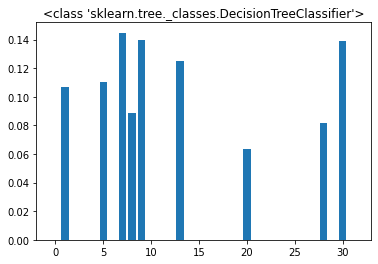

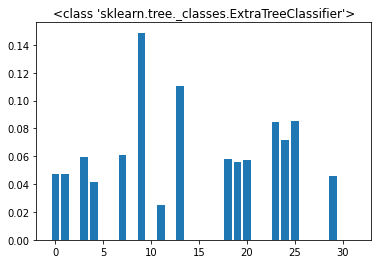

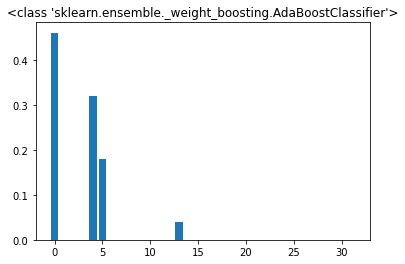

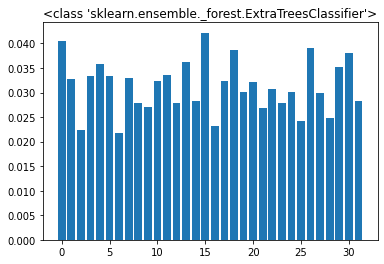

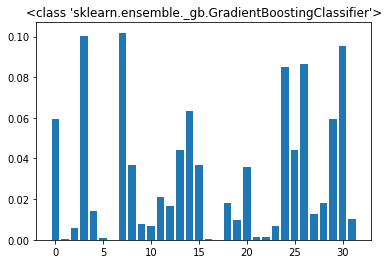

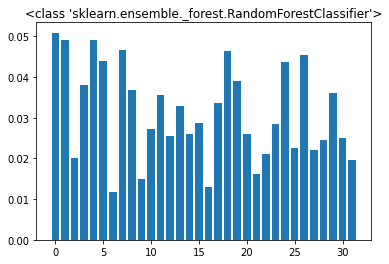

In [ ]:
###    Plotting feature importances

for idx,importance in importances:
  plt.figure()
  plt.bar(range(len(importance)),importance)
  plt.title(str(models[idx].__class__))

final >>>>    <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.5


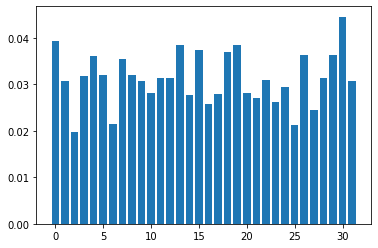

In [ ]:
#### TUNNING A SELECTED MODEL

final_model=ExtraTreesClassifier()
final_model.fit(X_train[:,:], y_train)
importance=final_model.feature_importances_
plt.bar(range(len(importance)),importance)
pred=final_model.predict(X_test)
print('final >>>>   ',str(final_model.__class__)+(100-len(str(final_model.__class__)))*'>'+'       ',accuracy_score(y_test,pred))

In [ ]:
#### TUNNING A SELECTED MODEL

for idx in range(0, 32, 4):
    final_model=NuSVC() #ExtraTreesClassifier()
    final_model.fit(X_train[:, idx: idx+4], y_train)
    pred=final_model.predict(X_test[:, idx: idx+4])
    print('final >>>>   ',str(final_model.__class__)+(100-len(str(final_model.__class__)))*'>'+'       ',accuracy_score(y_test,pred))

final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.4166666666666667
final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.4166666666666667
final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.4166666666666667
final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.25
final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.5
final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.3333333333333333
final >>>>    <class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>        0.4166666666666667
final >>>>    <class 'sklearn.svm._classes

In [ ]:
X_train.shape

(28, 32)

### Feature extraction method from WORKSHOP

In [ ]:

import os
import sys
from tempfile import gettempdir
from subprocess import call

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from scipy.signal import butter, lfilter, lfilter_zi

NOTCH_B, NOTCH_A = butter(4, np.array([55, 65])/(256/2), btype='bandstop')

def plot_multichannel(data, params=None): # 1 sample: with (59000, 8)
    """Create a plot to present multichannel data.

    Args:
        data (numpy.ndarray):  Multichannel Data [n_samples, n_channels]
        params (dict): information about the data acquisition device

    TODO Receive labels as arguments
    """
    fig, ax = plt.subplots()

    n_samples = data.shape[0]
    n_channels = data.shape[1]

    if params is not None:
        fs = params['sampling frequency']
        names = params['names of channels']
    else:
        fs = 1
        names = [''] * n_channels

    time_vec = np.arange(n_samples) / float(fs)

    data = np.fliplr(data)
    offset = 0
    for i_channel in range(n_channels):
        data_ac = data[:, i_channel] - np.mean(data[:, i_channel])
        offset = offset + 2 * np.max(np.abs(data_ac))
        ax.plot(time_vec, data_ac + offset, label=names[i_channel])

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')
    plt.legend()
    plt.draw()

def epoch(data, samples_epoch, samples_overlap=0):
    """Extract epochs from a time series.

    Given a 2D array of the shape [n_samples, n_channels]
    Creates a 3D array of the shape [wlength_samples, n_channels, n_epochs]

    Args:
        data (numpy.ndarray or list of lists): data [n_samples, n_channels]
        samples_epoch (int): window length in samples
        samples_overlap (int): Overlap between windows in samples

    Returns:
        (numpy.ndarray): epoched data of shape
    """

    if isinstance(data, list):
        data = np.array(data)

    n_samples, n_channels = data.shape

    samples_shift = samples_epoch - samples_overlap

    n_epochs =  int(np.floor((n_samples - samples_epoch) / float(samples_shift)) + 1)

    # Markers indicate where the epoch starts, and the epoch contains samples_epoch rows
    markers = np.asarray(range(0, n_epochs + 1)) * samples_shift
    markers = markers.astype(int)

    # Divide data in epochs
    epochs = np.zeros((samples_epoch, n_channels, n_epochs))

    for i in range(0, n_epochs):
        epochs[:, :, i] = data[markers[i]:markers[i] + samples_epoch, :]

    return epochs

def compute_feature_vector(eegdata, fs): #  # 1 sample: with (59000, 8)
    """Extract the features from the EEG.

    Args:
        eegdata (numpy.ndarray): array of dimension [number of samples,
                number of channels]
        fs (float): sampling frequency of eegdata

    Returns:
        (numpy.ndarray): feature matrix of shape [number of feature points,
            number of different features]
    """
    # 1. Compute the PSD
    winSampleLength, nbCh = eegdata.shape

    # Apply Hamming window
    w = np.hamming(winSampleLength)
    dataWinCentered = eegdata - np.mean(eegdata, axis=0)  # Remove offset
    dataWinCenteredHam = (dataWinCentered.T*w).T

    NFFT = nextpow2(winSampleLength)
    Y = np.fft.fft(dataWinCenteredHam, n=NFFT, axis=0)/winSampleLength
    PSD = 2*np.abs(Y[0:int(NFFT/2), :])
    f = fs/2*np.linspace(0, 1, int(NFFT/2))

    # SPECTRAL FEATURES
    # Average of band powers
    # Delta <4
    ind_delta, = np.where(f < 4)
    meanDelta = np.mean(PSD[ind_delta, :], axis=0)
    # Theta 4-8
    ind_theta, = np.where((f >= 4) & (f <= 8))
    meanTheta = np.mean(PSD[ind_theta, :], axis=0)
    # Alpha 8-12
    ind_alpha, = np.where((f >= 8) & (f <= 12))
    meanAlpha = np.mean(PSD[ind_alpha, :], axis=0)
    # Beta 12-30
    ind_beta, = np.where((f >= 12) & (f < 30))
    meanBeta = np.mean(PSD[ind_beta, :], axis=0)

    feature_vector = np.concatenate((meanDelta, meanTheta, meanAlpha,
                                     meanBeta), axis=0)

    feature_vector = np.log10(feature_vector)

    return feature_vector


In [ ]:
def nextpow2(i):
    """
    Find the next power of 2 for number i
    """
    n = 1
    while n < i:
        n *= 2
    return n


In [ ]:
workshop_run1=[]
for idx in range(len(eeg_run1)):
    workshop_run1.append(compute_feature_vector(eeg_run1[idx].T, 256))
workshop_run2=[]
for idx in range(len(eeg_run2)):
    workshop_run2.append(compute_feature_vector(eeg_run2[idx].T, 256))

In [ ]:
# TRAINING ALL THE MODELS
X = workshop_run1
y = labels_run1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = workshop_run1
y_train = labels_run1
X_test = workshop_run2
y_test = labels_run2

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

i=0
importances=[]
for model in models:
  i+=1
  try:
    model.fit(X_train,y_train)
  except Exception as e: print('Error in model.fit >>>',e)
  try:
    pred=model.predict(X_test)
  except Exception as e: print('Error in model.predict >>>',e)
  print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',accuracy_score(y_test,pred))
  try:
    importances.append([i-1,model.feature_importances_])
  except AttributeError:
    pass

1___<class 'sklearn.neighbors._classification.KNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.35
2___<class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
3___<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>>>>>>>>>>>>>>>>>>>>>>>__ 0.275
4___<class 'sklearn.linear_model._ridge.RidgeClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.325
5___<class 'sklearn.linear_model._ridge.RidgeClassifierCV'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.3
6___<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
7___<class 'sklearn.svm._classes.LinearSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.325
8___<class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.35
9___<class 'sklearn.svm._classes.SVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

No handles with labels found to put in legend.
No handles with labels found to put in legend.


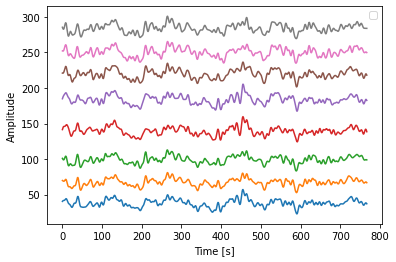

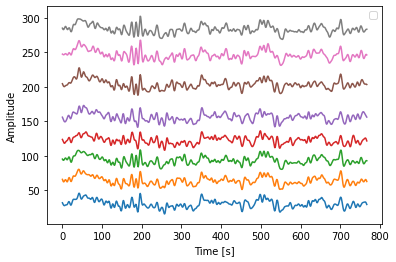

In [ ]:
plot_multichannel(eeg_run1[0].T)
plot_multichannel(eeg_run1[1].T)

In [ ]:
import lightgbm as lgb

X = workshop_run1
y = labels_run1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = workshop_run1
y_train = labels_run1
X_test = workshop_run2
y_test = labels_run2
num_round = 10
param = {'num_leaves': 31, 'objective': 'multiclass', 'num_classes':4}
param['metric'] = 'multi_error'
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

bst = lgb.train(param, train_data, num_round, valid_sets=[test_data])
test_pred = bst.predict(X_test)
print(accuracy_score(y_test,test_pred))

In [ ]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)